🔄 Generating synthetic regression data...
🚀 Running optimization experiments...
   Traditional Gradient Descent...
   Beam Search Gradient Descent...
GRADIENT DESCENT COMPARISON RESULTS

📊 FINAL METRICS:
Metric                    Traditional GD  Beam Search GD  Winner    
----------------------------------------------------------------------
Training Loss             0.015277        0.009776        Beam      
Validation Loss           0.016806        0.010593        Beam      
Param Distance            0.070620        0.011388        Beam      
Iterations                200             200             Traditional

🎯 PARAMETER RECOVERY:
True weights:        [-0.42375968 -0.45341411 -1.79564317 -0.33009019  0.73282908 -1.27423212]
Traditional final:   [-0.43583745 -0.48477922 -1.7485286  -0.34400638  0.74146993 -1.23722661]
Beam search final:   [-0.42943001 -0.45116575 -1.7989635  -0.33148547  0.74173665 -1.27463629]

🚀 IMPROVEMENT SUMMARY:
Training loss improvement: +36.01%
Validation l

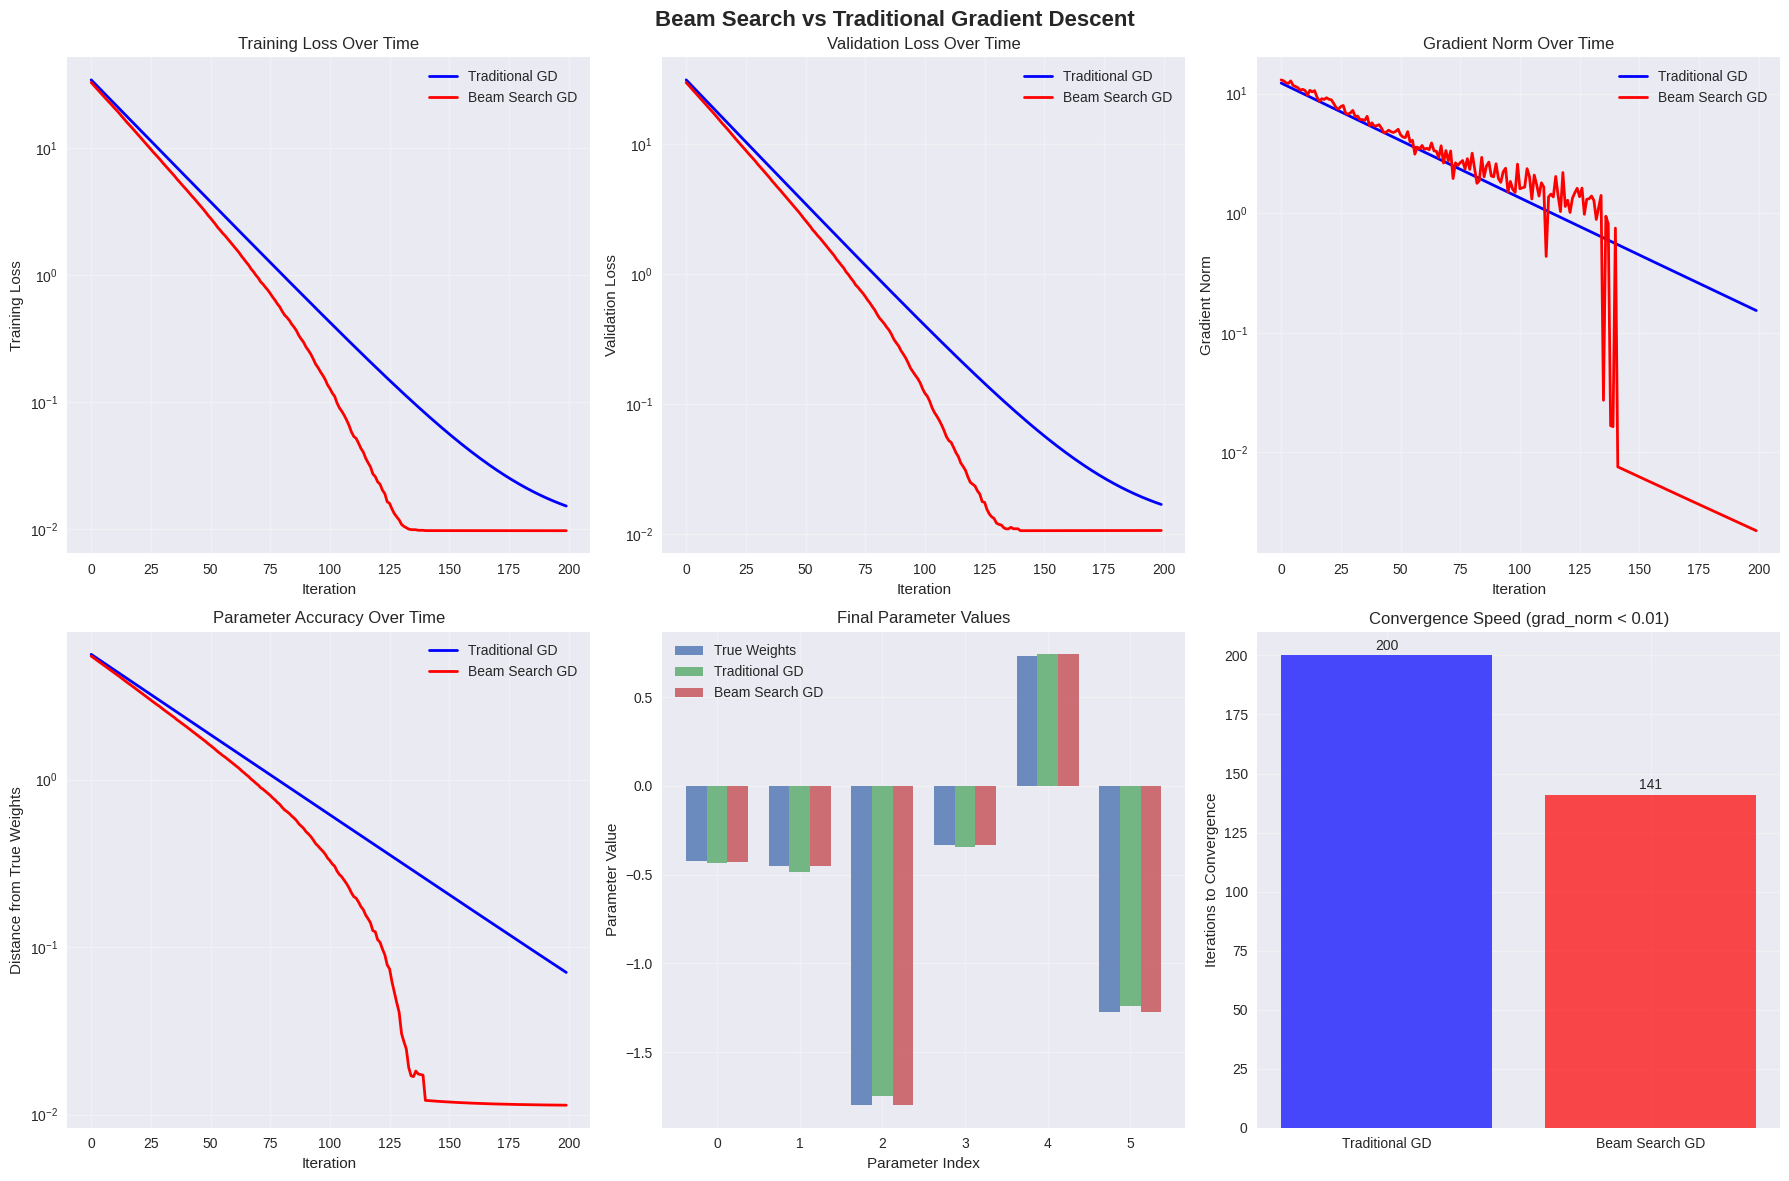

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')
np.random.seed(42)

class BeamGradientDescent:
    def __init__(self, beam_width=3, learning_rate=0.01, max_iters=200, noise_scale=0.5):
        self.beam_width = beam_width
        self.learning_rate = learning_rate
        self.max_iters = max_iters
        self.noise_scale = noise_scale
        self.history = []

    def fit(self, loss_fn, grad_fn, start_point, validation_fn=None):
        """Beam search gradient descent"""
        self.history = []

        # Initialize beams - each beam is a point in parameter space
        beams = [{'params': np.array(start_point), 'loss': loss_fn(start_point)}]

        for iteration in range(self.max_iters):
            candidates = []

            # For each current beam, generate multiple candidate next steps
            for beam in beams:
                grad = grad_fn(beam['params'])

                # Generate candidate directions
                for i in range(self.beam_width * 2):  # Generate more candidates than beam width
                    if i == 0:
                        # Always include the true gradient direction
                        candidate_grad = grad
                    else:
                        # Add noise to create alternative directions
                        noise = np.random.normal(0, self.noise_scale, size=grad.shape)
                        candidate_grad = grad + noise

                    # Take a step in this direction
                    new_params = beam['params'] - self.learning_rate * candidate_grad
                    new_loss = loss_fn(new_params)

                    candidates.append({
                        'params': new_params,
                        'loss': new_loss,
                        'grad': candidate_grad,
                        'parent_beam': beam
                    })

            # Select top beam_width candidates based on lowest loss
            candidates.sort(key=lambda x: x['loss'])
            beams = candidates[:self.beam_width]

            # Track the best beam
            best_beam = beams[0]
            val_loss = validation_fn(best_beam['params']) if validation_fn else None

            self.history.append({
                'iteration': iteration,
                'params': best_beam['params'].copy(),
                'train_loss': best_beam['loss'],
                'val_loss': val_loss,
                'grad_norm': np.linalg.norm(best_beam['grad']),
                'all_beams': [b['params'].copy() for b in beams]
            })

            # Early stopping
            if np.linalg.norm(best_beam['grad']) < 1e-6:
                break

        return self

class TraditionalGradientDescent:
    def __init__(self, learning_rate=0.01, max_iters=200):
        self.learning_rate = learning_rate
        self.max_iters = max_iters
        self.history = []

    def fit(self, loss_fn, grad_fn, start_point, validation_fn=None):
        """Traditional gradient descent"""
        self.history = []
        params = np.array(start_point)

        for iteration in range(self.max_iters):
            loss = loss_fn(params)
            grad = grad_fn(params)
            val_loss = validation_fn(params) if validation_fn else None

            self.history.append({
                'iteration': iteration,
                'params': params.copy(),
                'train_loss': loss,
                'val_loss': val_loss,
                'grad_norm': np.linalg.norm(grad)
            })

            # Update parameters
            params = params - self.learning_rate * grad

            # Early stopping
            if np.linalg.norm(grad) < 1e-6:
                break

        return self

def generate_regression_data(n_samples=1000, n_features=5, noise=0.1):
    """Generate synthetic regression data with train/validation split"""
    X = np.random.randn(n_samples, n_features)
    true_weights = np.random.randn(n_features + 1)  # +1 for bias

    # Add bias column
    X_with_bias = np.column_stack([np.ones(n_samples), X])
    y = X_with_bias @ true_weights + noise * np.random.randn(n_samples)

    # Split into train/validation
    X_train, X_val, y_train, y_val = train_test_split(
        X_with_bias, y, test_size=0.3, random_state=42
    )

    return X_train, X_val, y_train, y_val, true_weights

def create_loss_functions(X_train, y_train, X_val, y_val):
    """Create loss and gradient functions for linear regression"""

    def train_loss(weights):
        pred = X_train @ weights
        mse = np.mean((y_train - pred) ** 2)
        return mse

    def train_grad(weights):
        pred = X_train @ weights
        grad = -2 * X_train.T @ (y_train - pred) / len(y_train)
        return grad

    def val_loss(weights):
        pred = X_val @ weights
        mse = np.mean((y_val - pred) ** 2)
        return mse

    return train_loss, train_grad, val_loss

def plot_comparison(traditional_gd, beam_gd, true_weights):
    """Create comprehensive comparison plots"""
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Beam Search vs Traditional Gradient Descent', fontsize=16, fontweight='bold')

    # Extract histories
    trad_history = traditional_gd.history
    beam_history = beam_gd.history

    iterations_trad = [h['iteration'] for h in trad_history]
    iterations_beam = [h['iteration'] for h in beam_history]

    # 1. Training Loss
    axes[0,0].plot(iterations_trad, [h['train_loss'] for h in trad_history],
                   'b-', label='Traditional GD', linewidth=2)
    axes[0,0].plot(iterations_beam, [h['train_loss'] for h in beam_history],
                   'r-', label='Beam Search GD', linewidth=2)
    axes[0,0].set_xlabel('Iteration')
    axes[0,0].set_ylabel('Training Loss')
    axes[0,0].set_title('Training Loss Over Time')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)
    axes[0,0].set_yscale('log')

    # 2. Validation Loss
    axes[0,1].plot(iterations_trad, [h['val_loss'] for h in trad_history],
                   'b-', label='Traditional GD', linewidth=2)
    axes[0,1].plot(iterations_beam, [h['val_loss'] for h in beam_history],
                   'r-', label='Beam Search GD', linewidth=2)
    axes[0,1].set_xlabel('Iteration')
    axes[0,1].set_ylabel('Validation Loss')
    axes[0,1].set_title('Validation Loss Over Time')
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)
    axes[0,1].set_yscale('log')

    # 3. Gradient Norm
    axes[0,2].plot(iterations_trad, [h['grad_norm'] for h in trad_history],
                   'b-', label='Traditional GD', linewidth=2)
    axes[0,2].plot(iterations_beam, [h['grad_norm'] for h in beam_history],
                   'r-', label='Beam Search GD', linewidth=2)
    axes[0,2].set_xlabel('Iteration')
    axes[0,2].set_ylabel('Gradient Norm')
    axes[0,2].set_title('Gradient Norm Over Time')
    axes[0,2].legend()
    axes[0,2].grid(True, alpha=0.3)
    axes[0,2].set_yscale('log')

    # 4. Parameter Distance from True Values
    trad_distances = [np.linalg.norm(h['params'] - true_weights) for h in trad_history]
    beam_distances = [np.linalg.norm(h['params'] - true_weights) for h in beam_history]

    axes[1,0].plot(iterations_trad, trad_distances, 'b-', label='Traditional GD', linewidth=2)
    axes[1,0].plot(iterations_beam, beam_distances, 'r-', label='Beam Search GD', linewidth=2)
    axes[1,0].set_xlabel('Iteration')
    axes[1,0].set_ylabel('Distance from True Weights')
    axes[1,0].set_title('Parameter Accuracy Over Time')
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)
    axes[1,0].set_yscale('log')

    # 5. Final Parameter Comparison
    final_trad = trad_history[-1]['params']
    final_beam = beam_history[-1]['params']

    x_pos = np.arange(len(true_weights))
    width = 0.25

    axes[1,1].bar(x_pos - width, true_weights, width, label='True Weights', alpha=0.8)
    axes[1,1].bar(x_pos, final_trad, width, label='Traditional GD', alpha=0.8)
    axes[1,1].bar(x_pos + width, final_beam, width, label='Beam Search GD', alpha=0.8)
    axes[1,1].set_xlabel('Parameter Index')
    axes[1,1].set_ylabel('Parameter Value')
    axes[1,1].set_title('Final Parameter Values')
    axes[1,1].legend()
    axes[1,1].grid(True, alpha=0.3)

    # 6. Convergence Rate Comparison
    conv_threshold = 0.01  # Define convergence as when gradient norm < this

    trad_conv_iter = next((i for i, h in enumerate(trad_history)
                          if h['grad_norm'] < conv_threshold), len(trad_history))
    beam_conv_iter = next((i for i, h in enumerate(beam_history)
                          if h['grad_norm'] < conv_threshold), len(beam_history))

    methods = ['Traditional GD', 'Beam Search GD']
    conv_iters = [trad_conv_iter, beam_conv_iter]
    colors = ['blue', 'red']

    bars = axes[1,2].bar(methods, conv_iters, color=colors, alpha=0.7)
    axes[1,2].set_ylabel('Iterations to Convergence')
    axes[1,2].set_title(f'Convergence Speed (grad_norm < {conv_threshold})')
    axes[1,2].grid(True, alpha=0.3)

    # Add value labels on bars
    for bar, value in zip(bars, conv_iters):
        axes[1,2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                      str(value), ha='center', va='bottom')

    plt.tight_layout()
    return fig

def print_results_summary(traditional_gd, beam_gd, true_weights):
    """Print numerical comparison results"""
    trad_final = traditional_gd.history[-1]
    beam_final = beam_gd.history[-1]

    print("="*60)
    print("GRADIENT DESCENT COMPARISON RESULTS")
    print("="*60)

    print(f"\n📊 FINAL METRICS:")
    print(f"{'Metric':<25} {'Traditional GD':<15} {'Beam Search GD':<15} {'Winner':<10}")
    print("-" * 70)

    # Training Loss
    trad_loss = trad_final['train_loss']
    beam_loss = beam_final['train_loss']
    loss_winner = "Beam" if beam_loss < trad_loss else "Traditional"
    print(f"{'Training Loss':<25} {trad_loss:<15.6f} {beam_loss:<15.6f} {loss_winner:<10}")

    # Validation Loss
    trad_val = trad_final['val_loss']
    beam_val = beam_final['val_loss']
    val_winner = "Beam" if beam_val < trad_val else "Traditional"
    print(f"{'Validation Loss':<25} {trad_val:<15.6f} {beam_val:<15.6f} {val_winner:<10}")

    # Parameter Accuracy
    trad_dist = np.linalg.norm(trad_final['params'] - true_weights)
    beam_dist = np.linalg.norm(beam_final['params'] - true_weights)
    dist_winner = "Beam" if beam_dist < trad_dist else "Traditional"
    print(f"{'Param Distance':<25} {trad_dist:<15.6f} {beam_dist:<15.6f} {dist_winner:<10}")

    # Convergence Speed
    trad_iters = len(traditional_gd.history)
    beam_iters = len(beam_gd.history)
    iter_winner = "Beam" if beam_iters < trad_iters else "Traditional"
    print(f"{'Iterations':<25} {trad_iters:<15} {beam_iters:<15} {iter_winner:<10}")

    print(f"\n🎯 PARAMETER RECOVERY:")
    print(f"True weights:        {true_weights}")
    print(f"Traditional final:   {trad_final['params']}")
    print(f"Beam search final:   {beam_final['params']}")

    print(f"\n🚀 IMPROVEMENT SUMMARY:")
    loss_improvement = (trad_loss - beam_loss) / trad_loss * 100
    val_improvement = (trad_val - beam_val) / trad_val * 100

    print(f"Training loss improvement: {loss_improvement:+.2f}%")
    print(f"Validation loss improvement: {val_improvement:+.2f}%")
    print(f"Parameter accuracy improvement: {(trad_dist - beam_dist)/trad_dist*100:+.2f}%")

def main():
    # Generate data
    print("🔄 Generating synthetic regression data...")
    X_train, X_val, y_train, y_val, true_weights = generate_regression_data(
        n_samples=1000, n_features=5, noise=0.1
    )

    # Create loss functions
    train_loss_fn, train_grad_fn, val_loss_fn = create_loss_functions(
        X_train, y_train, X_val, y_val
    )

    # Initialize optimizers
    print("🚀 Running optimization experiments...")
    traditional_gd = TraditionalGradientDescent(learning_rate=0.01, max_iters=200)
    beam_gd = BeamGradientDescent(beam_width=3, learning_rate=0.01, max_iters=200, noise_scale=0.5)

    # Random starting point
    start_point = np.random.randn(len(true_weights)) * 2

    # Run optimizations
    print("   Traditional Gradient Descent...")
    traditional_gd.fit(train_loss_fn, train_grad_fn, start_point, val_loss_fn)

    print("   Beam Search Gradient Descent...")
    beam_gd.fit(train_loss_fn, train_grad_fn, start_point, val_loss_fn)

    # Print results
    print_results_summary(traditional_gd, beam_gd, true_weights)

    # Create plots
    print("\n📈 Creating comparison plots...")
    fig = plot_comparison(traditional_gd, beam_gd, true_weights)
    plt.show()

    return traditional_gd, beam_gd, true_weights

if __name__ == "__main__":
    traditional_gd, beam_gd, true_weights = main()

🚀 Running Comprehensive Optimization Evaluation

📊 Testing: High-Dim Quadratic (50D)
----------------------------------------
  Trial 1: Trad=24.548587, Beam=23.106808
  Trial 2: Trad=29.073209, Beam=27.527352
  Trial 3: Trad=23.484821, Beam=22.115280
  Trial 4: Trad=26.197393, Beam=24.731746
  Trial 5: Trad=23.804679, Beam=22.397495

📊 Testing: Rosenbrock (10D)
----------------------------------------
  Trial 1: Trad=nan, Beam=nan
  Trial 2: Trad=nan, Beam=nan
  Trial 3: Trad=nan, Beam=nan
  Trial 4: Trad=nan, Beam=nan
  Trial 5: Trad=nan, Beam=nan

📊 Testing: Ill-Conditioned Quadratic (20D)
----------------------------------------
  Trial 1: Trad=2.905636, Beam=2.719896
  Trial 2: Trad=3.537671, Beam=3.263657
  Trial 3: Trad=4.388189, Beam=4.059575
  Trial 4: Trad=2.378635, Beam=2.108985
  Trial 5: Trad=3.993586, Beam=3.718536

📊 Testing: Noisy Quadratic (30D)
----------------------------------------
  Trial 1: Trad=11.654636, Beam=11.117445
  Trial 2: Trad=10.991593, Beam=10.447904


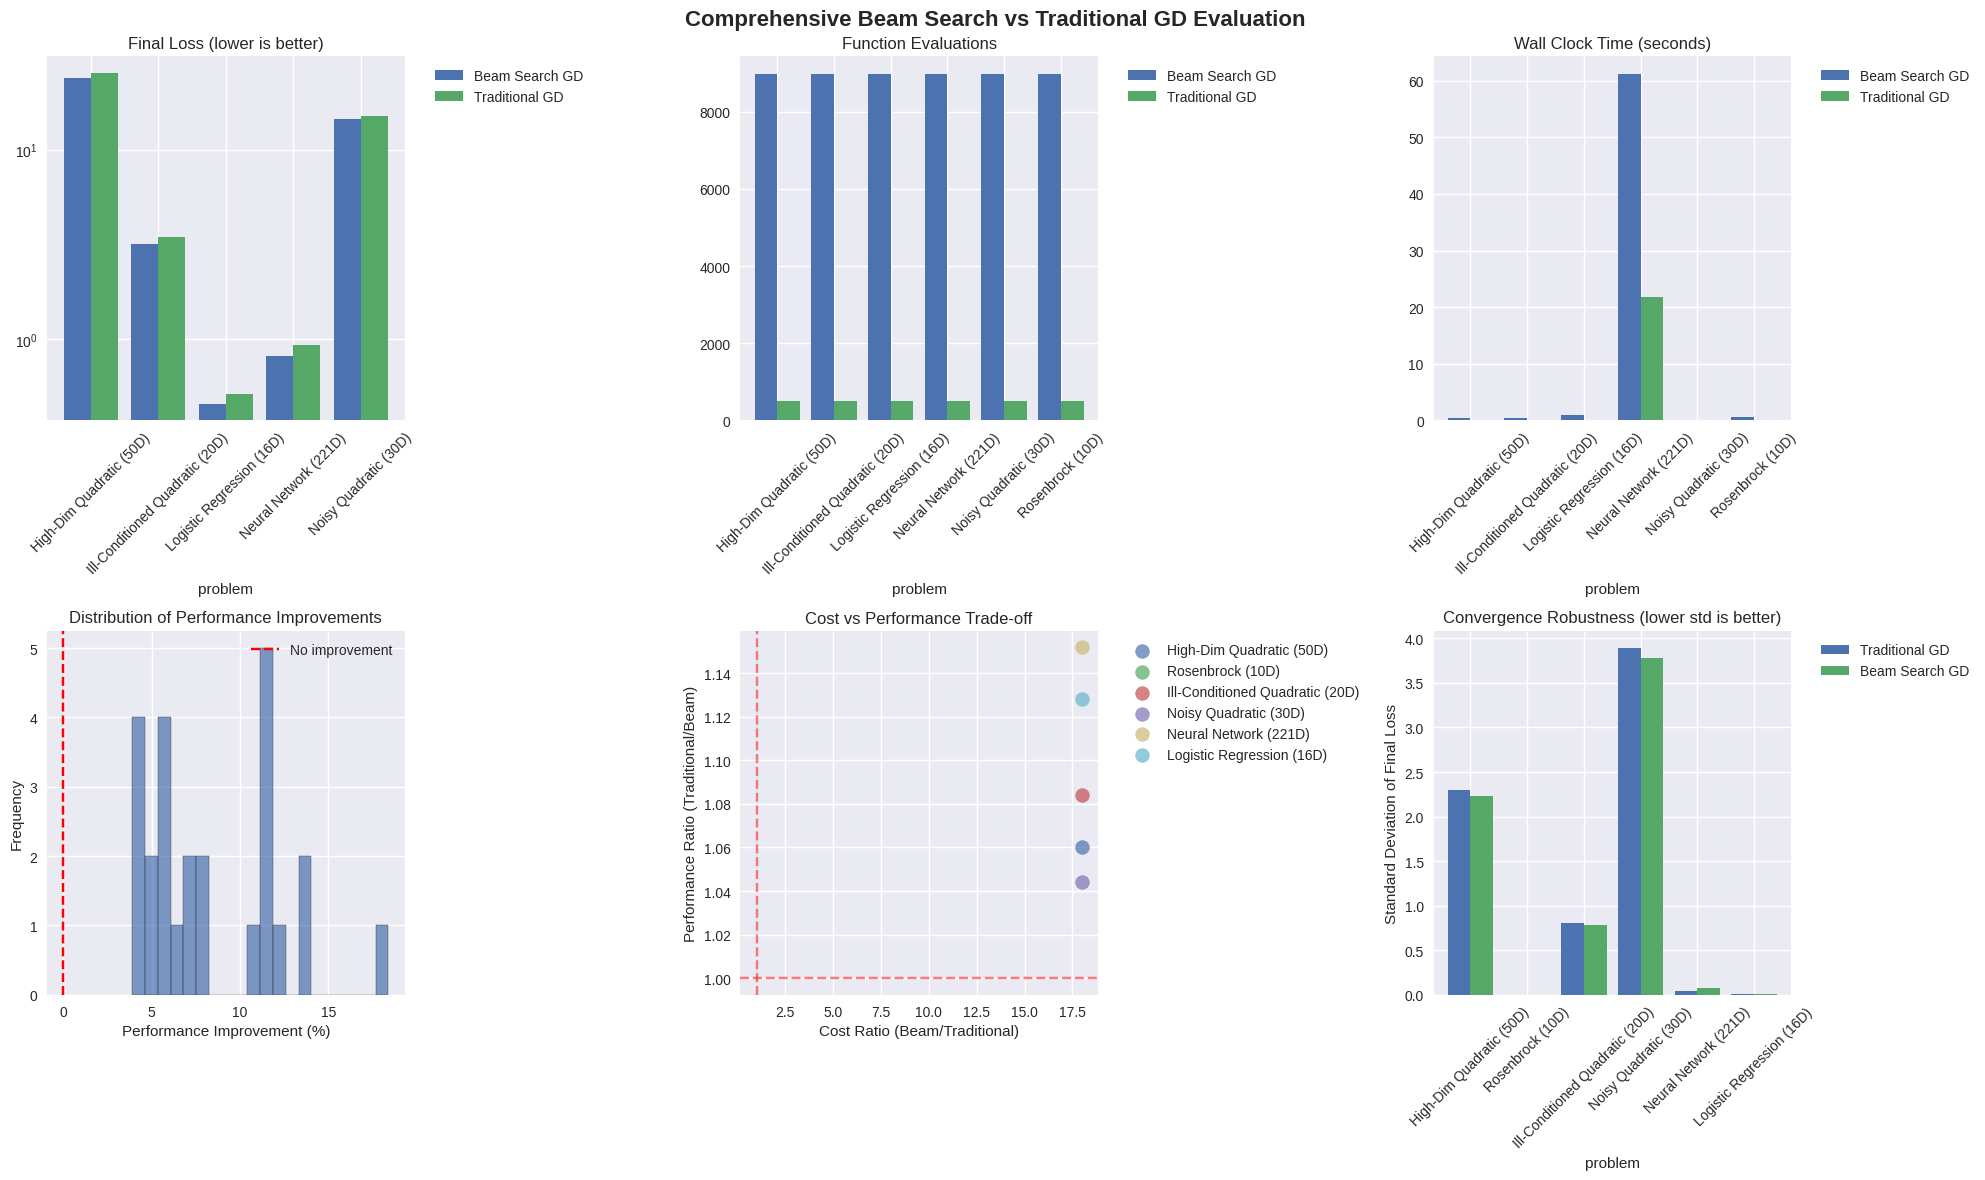


💾 Results saved to 'beam_search_evaluation_results.csv'


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import pandas as pd
from sklearn.datasets import make_regression, make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')
np.random.seed(42)

class OptimizationTracker:
    """Track computational costs and convergence metrics"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.function_evals = 0
        self.gradient_evals = 0
        self.start_time = None
        self.wall_time = 0.0

    def start_timing(self):
        self.start_time = time.time()

    def stop_timing(self):
        if self.start_time:
            self.wall_time = time.time() - self.start_time

    def record_function_eval(self):
        self.function_evals += 1

    def record_gradient_eval(self):
        self.gradient_evals += 1

class TrackedOptimizationProblem:
    """Wrap optimization problems with cost tracking"""
    def __init__(self, loss_fn, grad_fn, name, optimal_value=None, optimal_point=None):
        self.loss_fn = loss_fn
        self.grad_fn = grad_fn
        self.name = name
        self.optimal_value = optimal_value
        self.optimal_point = optimal_point
        self.tracker = OptimizationTracker()

    def loss(self, x):
        self.tracker.record_function_eval()
        return self.loss_fn(x)

    def grad(self, x):
        self.tracker.record_gradient_eval()
        return self.grad_fn(x)

    def reset_tracker(self):
        self.tracker.reset()

class BeamGradientDescent:
    def __init__(self, beam_width=3, learning_rate=0.01, max_iters=200, noise_scale=0.5):
        self.beam_width = beam_width
        self.learning_rate = learning_rate
        self.max_iters = max_iters
        self.noise_scale = noise_scale
        self.history = []

    def fit(self, problem, start_point):
        """Beam search gradient descent with cost tracking"""
        problem.reset_tracker()
        problem.tracker.start_timing()

        self.history = []
        beams = [{'params': np.array(start_point), 'loss': problem.loss(start_point)}]

        for iteration in range(self.max_iters):
            candidates = []

            for beam in beams:
                grad = problem.grad(beam['params'])

                # Generate candidate directions
                for i in range(self.beam_width * 2):
                    if i == 0:
                        candidate_grad = grad
                    else:
                        noise = np.random.normal(0, self.noise_scale, size=grad.shape)
                        candidate_grad = grad + noise

                    new_params = beam['params'] - self.learning_rate * candidate_grad
                    new_loss = problem.loss(new_params)

                    candidates.append({
                        'params': new_params,
                        'loss': new_loss,
                        'grad': candidate_grad
                    })

            # Select top candidates
            candidates.sort(key=lambda x: x['loss'])
            beams = candidates[:self.beam_width]

            best_beam = beams[0]
            optimality_gap = None
            if problem.optimal_value is not None:
                optimality_gap = abs(best_beam['loss'] - problem.optimal_value)

            self.history.append({
                'iteration': iteration,
                'params': best_beam['params'].copy(),
                'loss': best_beam['loss'],
                'grad_norm': np.linalg.norm(best_beam['grad']),
                'optimality_gap': optimality_gap,
                'function_evals': problem.tracker.function_evals,
                'gradient_evals': problem.tracker.gradient_evals
            })

            if np.linalg.norm(best_beam['grad']) < 1e-6:
                break

        problem.tracker.stop_timing()
        return self

class TraditionalGradientDescent:
    def __init__(self, learning_rate=0.01, max_iters=200):
        self.learning_rate = learning_rate
        self.max_iters = max_iters
        self.history = []

    def fit(self, problem, start_point):
        """Traditional gradient descent with cost tracking"""
        problem.reset_tracker()
        problem.tracker.start_timing()

        self.history = []
        params = np.array(start_point)

        for iteration in range(self.max_iters):
            loss = problem.loss(params)
            grad = problem.grad(params)

            optimality_gap = None
            if problem.optimal_value is not None:
                optimality_gap = abs(loss - problem.optimal_value)

            self.history.append({
                'iteration': iteration,
                'params': params.copy(),
                'loss': loss,
                'grad_norm': np.linalg.norm(grad),
                'optimality_gap': optimality_gap,
                'function_evals': problem.tracker.function_evals,
                'gradient_evals': problem.tracker.gradient_evals
            })

            params = params - self.learning_rate * grad

            if np.linalg.norm(grad) < 1e-6:
                break

        problem.tracker.stop_timing()
        return self

def create_test_problems():
    """Create a suite of challenging optimization problems"""
    problems = []

    # 1. High-dimensional quadratic (easy baseline)
    def quadratic_loss(x):
        return np.sum(x**2)
    def quadratic_grad(x):
        return 2*x
    problems.append(TrackedOptimizationProblem(
        quadratic_loss, quadratic_grad, "High-Dim Quadratic (50D)",
        optimal_value=0.0, optimal_point=np.zeros(50)
    ))

    # 2. Rosenbrock function (classic non-convex)
    def rosenbrock_loss(x):
        return sum(100*(x[1:] - x[:-1]**2)**2 + (1 - x[:-1])**2)
    def rosenbrock_grad(x):
        grad = np.zeros_like(x)
        grad[:-1] = -400*x[:-1]*(x[1:] - x[:-1]**2) - 2*(1 - x[:-1])
        grad[1:] += 200*(x[1:] - x[:-1]**2)
        return grad
    problems.append(TrackedOptimizationProblem(
        rosenbrock_loss, rosenbrock_grad, "Rosenbrock (10D)",
        optimal_value=0.0, optimal_point=np.ones(10)
    ))

    # 3. Ill-conditioned quadratic
    def ill_conditioned_loss(x):
        # Create ill-conditioned Hessian with condition number ~1000
        eigenvals = np.logspace(-3, 0, len(x))
        A = np.diag(eigenvals)
        return 0.5 * x.T @ A @ x
    def ill_conditioned_grad(x):
        eigenvals = np.logspace(-3, 0, len(x))
        A = np.diag(eigenvals)
        return A @ x
    problems.append(TrackedOptimizationProblem(
        ill_conditioned_loss, ill_conditioned_grad, "Ill-Conditioned Quadratic (20D)",
        optimal_value=0.0, optimal_point=np.zeros(20)
    ))

    # 4. Noisy quadratic (simulating measurement noise)
    noise_scale = 0.01
    def noisy_quadratic_loss(x):
        base_loss = np.sum(x**2)
        noise = noise_scale * np.random.randn()
        return base_loss + noise
    def noisy_quadratic_grad(x):
        base_grad = 2*x
        noise = noise_scale * np.random.randn(len(x))
        return base_grad + noise
    problems.append(TrackedOptimizationProblem(
        noisy_quadratic_loss, noisy_quadratic_grad, "Noisy Quadratic (30D)",
        optimal_value=0.0, optimal_point=np.zeros(30)
    ))

    # 5. Neural network regression (realistic ML problem)
    X, y = make_regression(n_samples=1000, n_features=20, n_targets=1,
                          noise=0.1, random_state=42)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Normalize data
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()
    X_train_scaled = scaler_X.fit_transform(X_train)
    y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()

    # Simple neural network: 20 -> 10 -> 1
    # Parameters: W1(20x10) + b1(10) + W2(10x1) + b2(1) = 221 parameters
    def neural_net_loss(params):
        # Unpack parameters
        W1 = params[:200].reshape(20, 10)
        b1 = params[200:210]
        W2 = params[210:220].reshape(10, 1)
        b2 = params[220]

        # Forward pass
        h1 = np.maximum(0, X_train_scaled @ W1 + b1)  # ReLU
        output = h1 @ W2 + b2

        # MSE loss
        mse = np.mean((output.flatten() - y_train_scaled)**2)
        # Add L2 regularization
        reg = 0.001 * (np.sum(W1**2) + np.sum(W2**2))
        return mse + reg

    def neural_net_grad(params):
        # Numerical gradient (for simplicity - could implement backprop)
        eps = 1e-5
        grad = np.zeros_like(params)
        for i in range(len(params)):
            params_plus = params.copy()
            params_minus = params.copy()
            params_plus[i] += eps
            params_minus[i] -= eps
            grad[i] = (neural_net_loss(params_plus) - neural_net_loss(params_minus)) / (2*eps)
        return grad

    problems.append(TrackedOptimizationProblem(
        neural_net_loss, neural_net_grad, "Neural Network (221D)"
    ))

    # 6. Logistic regression (econometrics favorite)
    X, y = make_classification(n_samples=1000, n_features=15, n_redundant=0,
                              n_informative=15, random_state=42)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Add intercept
    X_train_log = np.column_stack([np.ones(len(X_train)), X_train])

    def logistic_loss(params):
        z = X_train_log @ params
        # Stable sigmoid computation
        z = np.clip(z, -500, 500)  # Prevent overflow
        probs = 1 / (1 + np.exp(-z))
        probs = np.clip(probs, 1e-15, 1-1e-15)  # Prevent log(0)

        # Cross-entropy loss
        loss = -np.mean(y_train * np.log(probs) + (1-y_train) * np.log(1-probs))
        # L2 regularization
        reg = 0.001 * np.sum(params[1:]**2)  # Don't regularize intercept
        return loss + reg

    def logistic_grad(params):
        z = X_train_log @ params
        z = np.clip(z, -500, 500)
        probs = 1 / (1 + np.exp(-z))

        grad = X_train_log.T @ (probs - y_train) / len(y_train)
        # Add regularization gradient
        reg_grad = 0.001 * 2 * params
        reg_grad[0] = 0  # Don't regularize intercept
        return grad + reg_grad

    problems.append(TrackedOptimizationProblem(
        logistic_loss, logistic_grad, "Logistic Regression (16D)"
    ))

    return problems

def run_comprehensive_evaluation():
    """Run beam search vs traditional GD on all test problems"""
    problems = create_test_problems()
    results = []

    # Common hyperparameters
    learning_rate = 0.001  # Smaller for harder problems
    max_iters = 500
    beam_width = 3
    noise_scale = 0.3
    n_trials = 5  # Multiple random starts for robustness

    print("🚀 Running Comprehensive Optimization Evaluation")
    print("=" * 60)

    for problem in problems:
        print(f"\n📊 Testing: {problem.name}")
        print("-" * 40)

        problem_results = []

        for trial in range(n_trials):
            # Generate random starting point
            if "Neural Network" in problem.name:
                start_point = np.random.randn(221) * 0.1  # Small init for NN
            elif "Logistic" in problem.name:
                start_point = np.random.randn(16) * 0.1
            else:
                dim = 50 if "High-Dim" in problem.name else (20 if "Ill-Conditioned" in problem.name else (30 if "Noisy" in problem.name else 10))
                start_point = np.random.randn(dim) * 2.0

            # Traditional GD
            trad_gd = TraditionalGradientDescent(learning_rate=learning_rate, max_iters=max_iters)
            trad_gd.fit(problem, start_point)

            trad_final = trad_gd.history[-1]
            trad_result = {
                'problem': problem.name,
                'trial': trial,
                'method': 'Traditional GD',
                'final_loss': trad_final['loss'],
                'optimality_gap': trad_final['optimality_gap'],
                'iterations': len(trad_gd.history),
                'function_evals': trad_final['function_evals'],
                'gradient_evals': trad_final['gradient_evals'],
                'wall_time': problem.tracker.wall_time,
                'final_grad_norm': trad_final['grad_norm']
            }

            # Beam Search GD
            beam_gd = BeamGradientDescent(beam_width=beam_width, learning_rate=learning_rate,
                                        max_iters=max_iters, noise_scale=noise_scale)
            beam_gd.fit(problem, start_point)

            beam_final = beam_gd.history[-1]
            beam_result = {
                'problem': problem.name,
                'trial': trial,
                'method': 'Beam Search GD',
                'final_loss': beam_final['loss'],
                'optimality_gap': beam_final['optimality_gap'],
                'iterations': len(beam_gd.history),
                'function_evals': beam_final['function_evals'],
                'gradient_evals': beam_final['gradient_evals'],
                'wall_time': problem.tracker.wall_time,
                'final_grad_norm': beam_final['grad_norm']
            }

            problem_results.extend([trad_result, beam_result])

            print(f"  Trial {trial+1}: Trad={trad_final['loss']:.6f}, Beam={beam_final['loss']:.6f}")

        results.extend(problem_results)

    return pd.DataFrame(results)

def analyze_results(df):
    """Comprehensive analysis of optimization results"""
    print("\n" + "="*80)
    print("COMPREHENSIVE EVALUATION RESULTS")
    print("="*80)

    # Summary statistics by problem and method
    summary = df.groupby(['problem', 'method']).agg({
        'final_loss': ['mean', 'std', 'min'],
        'function_evals': ['mean', 'std'],
        'gradient_evals': ['mean', 'std'],
        'wall_time': ['mean', 'std'],
        'iterations': ['mean', 'std']
    }).round(6)

    print("\n📊 SUMMARY STATISTICS")
    print(summary)

    # Head-to-head comparison
    print(f"\n🥊 HEAD-TO-HEAD COMPARISON")
    print("-" * 50)

    beam_wins = 0
    total_comparisons = 0

    for problem in df['problem'].unique():
        problem_data = df[df['problem'] == problem]

        trad_losses = problem_data[problem_data['method'] == 'Traditional GD']['final_loss']
        beam_losses = problem_data[problem_data['method'] == 'Beam Search GD']['final_loss']

        trad_mean = trad_losses.mean()
        beam_mean = beam_losses.mean()

        improvement = (trad_mean - beam_mean) / trad_mean * 100
        winner = "BEAM" if beam_mean < trad_mean else "TRAD"

        if beam_mean < trad_mean:
            beam_wins += 1
        total_comparisons += 1

        print(f"{problem:<30} | {winner} | {improvement:+7.2f}% improvement")

    print(f"\nBeam Search wins: {beam_wins}/{total_comparisons} problems")

    # Computational efficiency analysis
    print(f"\n⚡ COMPUTATIONAL EFFICIENCY")
    print("-" * 50)

    efficiency_data = []
    for problem in df['problem'].unique():
        problem_data = df[df['problem'] == problem]

        trad_data = problem_data[problem_data['method'] == 'Traditional GD']
        beam_data = problem_data[problem_data['method'] == 'Beam Search GD']

        # Cost per unit improvement
        trad_loss_improvement = trad_data['final_loss'].mean()
        beam_loss_improvement = beam_data['final_loss'].mean()

        trad_cost = trad_data['function_evals'].mean()
        beam_cost = beam_data['function_evals'].mean()

        cost_ratio = beam_cost / trad_cost
        performance_ratio = trad_loss_improvement / beam_loss_improvement if beam_loss_improvement > 0 else float('inf')

        efficiency_ratio = performance_ratio / cost_ratio  # Performance gain per unit cost

        efficiency_data.append({
            'problem': problem,
            'cost_ratio': cost_ratio,
            'performance_ratio': performance_ratio,
            'efficiency_ratio': efficiency_ratio
        })

        print(f"{problem:<30} | Cost: {cost_ratio:.1f}x | Perf: {performance_ratio:.2f}x | Eff: {efficiency_ratio:.2f}")

    return summary, efficiency_data

def create_comprehensive_plots(df):
    """Create comprehensive visualization of results"""
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    fig.suptitle('Comprehensive Beam Search vs Traditional GD Evaluation', fontsize=16, fontweight='bold')

    # 1. Final Loss Comparison
    ax = axes[0, 0]
    loss_data = df.pivot_table(values='final_loss', index='problem', columns='method', aggfunc='mean')
    loss_data.plot(kind='bar', ax=ax, rot=45, width=0.8)
    ax.set_yscale('log')
    ax.set_title('Final Loss (lower is better)')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    # 2. Function Evaluations
    ax = axes[0, 1]
    eval_data = df.pivot_table(values='function_evals', index='problem', columns='method', aggfunc='mean')
    eval_data.plot(kind='bar', ax=ax, rot=45, width=0.8)
    ax.set_title('Function Evaluations')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    # 3. Wall Clock Time
    ax = axes[0, 2]
    time_data = df.pivot_table(values='wall_time', index='problem', columns='method', aggfunc='mean')
    time_data.plot(kind='bar', ax=ax, rot=45, width=0.8)
    ax.set_title('Wall Clock Time (seconds)')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    # 4. Improvement Distribution
    ax = axes[1, 0]
    improvements = []
    for problem in df['problem'].unique():
        problem_data = df[df['problem'] == problem]
        trad_losses = problem_data[problem_data['method'] == 'Traditional GD']['final_loss']
        beam_losses = problem_data[problem_data['method'] == 'Beam Search GD']['final_loss']

        for trad_loss, beam_loss in zip(trad_losses, beam_losses):
            improvement = (trad_loss - beam_loss) / trad_loss * 100
            improvements.append(improvement)

    ax.hist(improvements, bins=20, alpha=0.7, edgecolor='black')
    ax.axvline(0, color='red', linestyle='--', label='No improvement')
    ax.set_xlabel('Performance Improvement (%)')
    ax.set_ylabel('Frequency')
    ax.set_title('Distribution of Performance Improvements')
    ax.legend()

    # 5. Cost vs Performance Scatter
    ax = axes[1, 1]
    for problem in df['problem'].unique():
        problem_data = df[df['problem'] == problem]
        trad_data = problem_data[problem_data['method'] == 'Traditional GD']
        beam_data = problem_data[problem_data['method'] == 'Beam Search GD']

        cost_ratio = beam_data['function_evals'].mean() / trad_data['function_evals'].mean()
        perf_ratio = trad_data['final_loss'].mean() / beam_data['final_loss'].mean()

        ax.scatter(cost_ratio, perf_ratio, s=100, alpha=0.7, label=problem)

    ax.axhline(1, color='red', linestyle='--', alpha=0.5)
    ax.axvline(1, color='red', linestyle='--', alpha=0.5)
    ax.set_xlabel('Cost Ratio (Beam/Traditional)')
    ax.set_ylabel('Performance Ratio (Traditional/Beam)')
    ax.set_title('Cost vs Performance Trade-off')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    # 6. Convergence Robustness
    ax = axes[1, 2]
    convergence_data = []
    for problem in df['problem'].unique():
        problem_data = df[df['problem'] == problem]

        trad_std = problem_data[problem_data['method'] == 'Traditional GD']['final_loss'].std()
        beam_std = problem_data[problem_data['method'] == 'Beam Search GD']['final_loss'].std()

        convergence_data.append({
            'problem': problem,
            'Traditional GD': trad_std,
            'Beam Search GD': beam_std
        })

    conv_df = pd.DataFrame(convergence_data).set_index('problem')
    conv_df.plot(kind='bar', ax=ax, rot=45, width=0.8)
    ax.set_title('Convergence Robustness (lower std is better)')
    ax.set_ylabel('Standard Deviation of Final Loss')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    return fig

def main():
    # Run comprehensive evaluation
    results_df = run_comprehensive_evaluation()

    # Analyze results
    summary, efficiency_data = analyze_results(results_df)

    # Create plots
    print("\n📈 Creating comprehensive plots...")
    fig = create_comprehensive_plots(results_df)
    plt.show()

    # Save results
    results_df.to_csv('beam_search_evaluation_results.csv', index=False)
    print("\n💾 Results saved to 'beam_search_evaluation_results.csv'")

    return results_df, summary, efficiency_data

if __name__ == "__main__":
    results_df, summary, efficiency_data = main()